# Introduction to SNPE

<br/>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
sys.path.append("../")
from common import MultivariateGaussianMDN, mog_log_prob, mog_sample

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [90]:
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import pi
from torch.utils import data
import numpy as np
from torch import tensor, ones, zeros, eye
_ = torch.manual_seed(0)

### Define a toy simulator

In [6]:
def simulate(theta):
    return theta + 0.3*torch.sin(2*pi*theta) + torch.rand((theta.shape[0], 1)) * 0.2 - 0.1

### Define an observation

In [93]:
xo = tensor([[0.9]])

### Define a prior

In [94]:
from torch.distributions import Normal

N = 4000
prior = Normal(0.5*ones(1), 0.3*ones(1))

### Generate simulated data

In [95]:
thetas = prior.sample((N,))
xs = []
for theta in thetas:
    xs.append(simulate(theta))

In [96]:
xs = torch.cat(xs)

# Exercise 1: Train neural network to learn $p(\theta | x)$

In [54]:
dataset = data.TensorDataset(thetas, xs)
train_loader = data.DataLoader(
    dataset, batch_size=50,
)
mdn = MultivariateGaussianMDN(
    features=1,
    hidden_net=nn.Sequential(
        nn.Linear(1, 30),
        nn.ReLU(),
        nn.Linear(30, 30),
        nn.ReLU(),
        nn.Linear(30, 30),
        nn.ReLU(),
    ),
    num_components=5,

    hidden_features=30,
)
opt = optim.Adam(mdn.parameters(), lr=0.001)
for e in range(200):
    for theta_batch, x_batch in train_loader:
        opt.zero_grad()
        logits, means, variances = mdn.get_mixture_components(x_batch)
        out = mog_log_prob(theta_batch, logits, means, variances)
        loss = -out.sum()
        loss.backward()
        opt.step()

### Draw samples from posterior

In [71]:
n = 100

logits, means, variances = mdn.get_mixture_components(xo)

samples = []
for _ in range(n):
    samples.append(mog_sample(logits, means, variances))

In [72]:
samples = torch.cat(samples).detach()

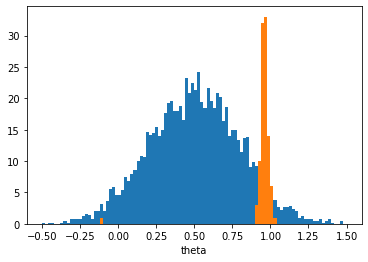

In [73]:
fig = plt.figure(figsize=(6, 4))
plt.hist(thetas.numpy(), range=(-0.5, 1.5), bins=100, weights=0.2*np.ones(4000))
plt.hist(samples.numpy(), range=(-0.5, 1.5), bins=100)
plt.xlabel('theta')
plt.show()

# Exercise 2: Test amortization for a few different xo

### Amortization

In [74]:
xo = tensor([[0.35]])

logits, means, variances = mdn.get_mixture_components(xo)

samples = []
for _ in range(n):
    samples.append(mog_sample(logits, means, variances)) 

samples = torch.cat(samples).detach()

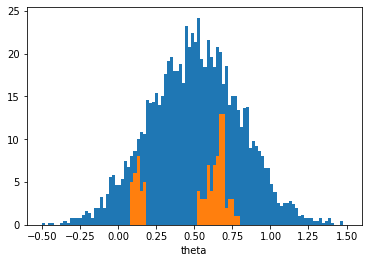

In [75]:
fig = plt.figure(figsize=(6, 4))
plt.hist(thetas.numpy(), range=(-0.5, 1.5), bins=100, weights=0.2*np.ones(4000))
plt.hist(samples.numpy(), range=(-0.5, 1.5), bins=100)
plt.xlabel('theta')
plt.show()

### Assessing performance via posterior predictives

In [78]:
xo = tensor([[0.35]])

logits, means, variances = mdn.get_mixture_components(xo)

samples = []
for _ in range(n):
    samples.append(mog_sample(logits, means, variances)) 

samples = torch.cat(samples).detach()

posterior_predictives = simulate(samples)

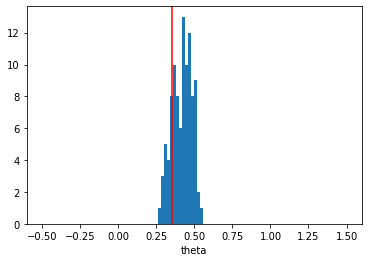

In [86]:
fig = plt.figure(figsize=(6, 4))
plt.hist(posterior_predictives[:,0].numpy(), range=(-0.5, 1.5), bins=100)
plt.axvline(xo.numpy(), c="r")
plt.xlabel('theta')
plt.show()

# Exercise 3: Assess performance for a different observation

In [87]:
xo = tensor([[0.9]])

logits, means, variances = mdn.get_mixture_components(xo)

samples = []
for _ in range(n):
    samples.append(mog_sample(logits, means, variances)) 

samples = torch.cat(samples).detach()

posterior_predictives = simulate(samples)

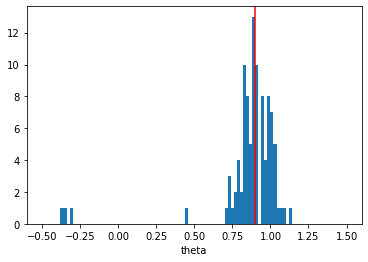

In [88]:
fig = plt.figure(figsize=(6, 4))
plt.hist(posterior_predictives[:,0].numpy(), range=(-0.5, 1.5), bins=100)
plt.axvline(xo.numpy(), c="r")
plt.xlabel('theta')
plt.show()

# Embedding network

One can pass the simulated data $x$ through **any** neural network before regressing on the Mixture Parameters (e.g. CNN, LSTM, GNN,...)

### Mixture Density Networks

<img src="../01_density_estimation/figures/architecture.png" alt="drawing" width="600"/>

The loss is now the probability under this mixture of Gaussians  <br/>

$L = -\sum_i \log p(t_i) = -\sum_i \log \sum_j \alpha_{j,i} N(t_i; \mu_{j,i}, \sigma_{j,i})$  <br/>

We learn the mixture components $\alpha_j$, the means $\mu_j$, and the variances $\sigma_j$.

# Example from Neuroscience

At this point, we should maybe add a HH example.

Try to predict membrane conductances (Sodium and Potassium) from observed voltage trace (left). Ground truth in yellow, the prediction of the MDN in red.

<img src="../01_density_estimation/figures/full_HH_fig.png" alt="drawing" width="600"/>

Picture credit to Pedro Gonçalves et al., Cosyne 2017

# Focused (multi-round) inference

Not really sure what to say here yet...